Another test of the 2PCF for the subvolumes. This comparison will compare

- 2PCF computed from the subvolume cutout of the entire box _after_ it's populated

versus

- 2PCF computed from the subvolume cutout of the entire box _before_ it's populated

In [1]:
import os
import time
import pickle
import numpy as np 
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables import tpcf
from halotools.empirical_models.factories.mock_helpers import three_dim_pos_bundle

from ccppabc.code.data import data_RR
from ccppabc.code.data import data_random
from ccppabc.code.data import xi_binedges
from ccppabc.code.data import data_cov

from ccppabc.code import util

import matplotlib.pyplot as plt
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline

In [2]:
xi_bin = xi_binedges()

# Entire full volume $\xi(r)$ using _Analytic Randoms_

In [4]:
halocat = CachedHaloCatalog(simname='multidark', redshift=0, halo_finder='rockstar')

model1 = PrebuiltHodModelFactory('zheng07', threshold=-21)
model1.populate_mock(halocat)
pos1 = three_dim_pos_bundle(model1.mock.galaxy_table, 'x', 'y', 'z')

xi_full_analytic = tpcf(pos1, xi_bin, period=model1.mock.Lbox, max_sample_size=int(pos1.shape[0]), estimator='Natural')

# Entire full volume $\xi(r)$ using _pair counts_
>enforce_PBC = False

In [5]:
model2 = PrebuiltHodModelFactory('zheng07', threshold=-21)
model2.populate_mock(halocat, enforce_PBC=False)  #
pos2 = three_dim_pos_bundle(model2.mock.galaxy_table, 'x', 'y', 'z')

full_randoms = data_random(box='md_all')
full_RR = data_RR(box='md_all')
full_NR = len(full_randoms)
rmax = xi_bin.max()

xi_full_pc = tpcf(
    pos2, xi_bin,
    randoms=full_randoms, 
    do_auto=True, do_cross=False, max_sample_size=int(pos2.shape[0]), 
    estimator='Natural', 
    approx_cell1_size=[rmax, rmax, rmax], 
    approx_cellran_size=[rmax, rmax, rmax], 
    RR_precomputed=full_RR, 
    NR_precomputed=full_NR)

# Comparison between full volume $\xi(r)$ 
using `analytic randoms` versus `pair counts`

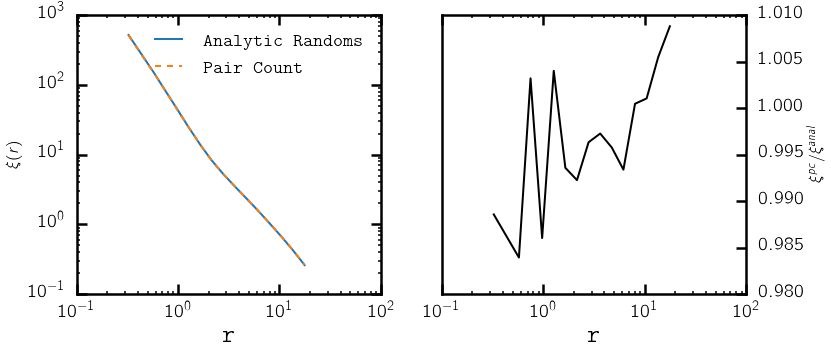

In [6]:
prettyplot()
pretty_colors = prettycolors()
fig = plt.figure(figsize=(12, 5))
sub1 = fig.add_subplot(121)
sub1.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_full_analytic, c=pretty_colors[1], lw=2, ls='-', label='Analytic Randoms')
sub1.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_full_pc, c=pretty_colors[3], lw=2, ls='--', label='Pair Count')
sub1.set_xscale('log')
sub1.set_xlabel('r', fontsize=25)
sub1.set_ylabel(r'$\xi(r)$')
sub1.set_yscale('log')
sub1.legend(loc='upper right')

sub2 = fig.add_subplot(122)
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_full_pc/xi_full_analytic, c='k', lw=2, ls='-', label='Ratio')
sub2.set_xscale('log')
sub2.set_xlabel('r', fontsize=25)
sub2.set_ylabel(r'$\xi^{pc}/\xi^{anal}$')
sub2.yaxis.tick_right()
sub2.yaxis.set_label_position("right")

## No significant difference between full volume $\xi(r)$ computed with analytic randoms versus pair counts

# 2PCF of subvolume cut-out _after_ entire volume is populated

In [7]:
Nsub = 10

In [8]:
sub_afterpop_file = '/export/bbq2/hahn/ccppabc/dump/precomputed_xi_sub_afterpop.'+str(Nsub)+'.p'
if os.path.isfile(sub_afterpop_file): 
    xi_sub_afterpop_list = pickle.load(open(sub_afterpop_file, 'rb'))
    xi_sub_afterpop_tot = np.zeros(len(xi_bin)-1)
    for iii in range(len(xi_sub_afterpop_list)):
        xi_sub_afterpop_tot += xi_sub_afterpop_list[iii]
        
    xi_sub_afterpop_avg = xi_sub_afterpop_tot/np.float(len(xi_sub_afterpop_list))
else: 
    model3 = PrebuiltHodModelFactory('zheng07', threshold=-21)
    model3.populate_mock(halocat, enforce_PBC=False)  #
    subvol_id = util.mk_id_column(table=model3.mock.galaxy_table)
    pos3 = three_dim_pos_bundle(model3.mock.galaxy_table, 'x', 'y', 'z')

    sub_randoms = data_random(box='md_sub')
    sub_RR = data_RR(box='md_sub')
    sub_NR = len(sub_randoms)

    xi_sub_afterpop_list = []
    xi_sub_afterpop_tot = np.zeros(len(xi_bin)-1)
    for iid in np.unique(subvol_id)[:Nsub]: 
        in_subvol = np.where(subvol_id == iid)
        subvol_pos3 = pos3[in_subvol]

        xi_sub_afterpop = tpcf(
            subvol_pos3, xi_bin,
            randoms=sub_randoms, 
            period=None, 
            do_auto=True, do_cross=False, max_sample_size=int(subvol_pos3.shape[0]), 
            estimator='Natural', 
            approx_cell1_size=[rmax, rmax, rmax], 
            approx_cellran_size=[rmax, rmax, rmax], 
            RR_precomputed=sub_RR, 
            NR_precomputed=sub_NR)

        xi_sub_afterpop_list.append(xi_sub_afterpop)
        xi_sub_afterpop_tot += xi_sub_afterpop

    xi_sub_afterpop_avg = xi_sub_afterpop_tot/np.float(len(xi_sub_afterpop_list))
    
    pickle.dump(xi_sub_afterpop_list, open(sub_afterpop_file, 'wb'))

# 2PCF of subvolume cut-out _before_ entire volume is populated
subvolume is populated separately through the `masking_function` keyword in `populate_mock`

In [9]:
sub_beforepop_file = '/export/bbq2/hahn/ccppabc/dump/precomputed_xi_sub_beforepop.'+str(Nsub)+'.p'
if os.path.isfile(sub_beforepop_file): 
    xi_sub_beforepop_list = pickle.load(open(sub_beforepop_file, 'rb'))
    xi_sub_beforepop_tot = np.zeros(len(xi_bin)-1)
    for iii in range(len(xi_sub_afterpop_list)):
        xi_sub_beforepop_tot += xi_sub_beforepop_list[iii]
        
    xi_sub_beforepop_avg = xi_sub_beforepop_tot/np.float(len(xi_sub_beforepop_list))
else: 
    model4 = PrebuiltHodModelFactory('zheng07', threshold=-21)
    model4.new_haloprop_func_dict = {'sim_subvol': util.mk_id_column}

    xi_sub_beforepop_list = []
    xi_sub_beforepop_tot = np.zeros(len(xi_bin)-1)
    for ii in range(Nsub+1): 
        simsubvol = lambda x: util.mask_func(x, ii)
        model4.populate_mock(halocat, masking_function=simsubvol, enforce_PBC=False)

        pos4 = three_dim_pos_bundle(model4.mock.galaxy_table, 'x', 'y', 'z')

        xi_sub_beforepop = tpcf(pos4, xi_bin,
                                randoms=sub_randoms, 
                                period=None, 
                                do_auto=True, 
                                do_cross=False, 
                                max_sample_size=int(pos4.shape[0]), 
                                estimator='Natural', 
                                approx_cell1_size=[rmax, rmax, rmax], 
                                approx_cellran_size=[rmax, rmax, rmax], 
                                RR_precomputed=sub_RR, 
                                NR_precomputed=sub_NR)

        xi_sub_beforepop_list.append(xi_sub_beforepop)
        xi_sub_beforepop_tot += xi_sub_beforepop

    xi_sub_beforepop_avg = xi_sub_beforepop_tot / np.float(len(xi_sub_beforepop_list))
    
    pickle.dump(xi_sub_beforepop_list, open(sub_beforepop_file, 'wb'))

# Subvolume Comparison 
Now compare subvolume $\xi(r)$ to the full volume $\xi(r)$. 

For subvolumes, the can be cut out from the _populated_ full volume or cut out first then _populated_. 
So they can either be 

- cut out *after* being populated

or 

- cut out *before* being populated

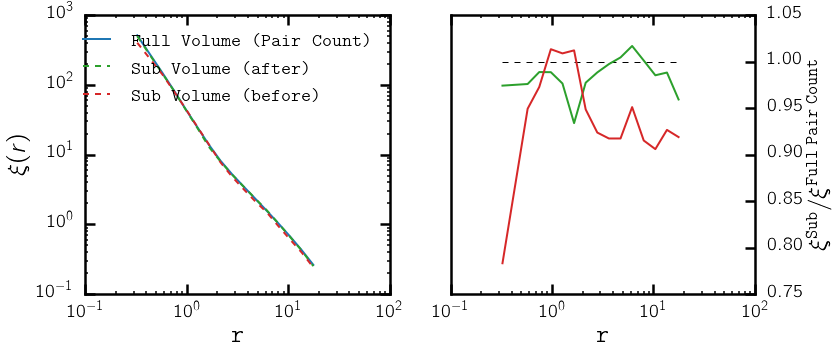

In [10]:
prettyplot()
pretty_colors = prettycolors()
fig = plt.figure(figsize=(12, 5))
sub1 = fig.add_subplot(121)
sub1.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_full_pc, c=pretty_colors[1], lw=2, ls='-', label='Full Volume (Pair Count)')
sub1.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_sub_afterpop_avg, c=pretty_colors[5], lw=2, ls='--', label='Sub Volume (after)')
sub1.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_sub_beforepop_avg, c=pretty_colors[7], lw=2, ls='--', label='Sub Volume (before)')
sub1.set_xscale('log')
sub1.set_xlabel('r', fontsize=25)
sub1.set_ylabel(r'$\xi(r)$', fontsize=25)
sub1.set_yscale('log')
sub1.legend(loc='upper right')

sub2 = fig.add_subplot(122)
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), np.repeat(1.0, len(xi_bin)-1), c='k', ls='--')
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_sub_afterpop_avg/xi_full_pc, c=pretty_colors[5], lw=2, ls='-', label='Sub Volume (after)')
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_sub_beforepop_avg/xi_full_pc, c=pretty_colors[7], lw=2, ls='-', label='Sub Volume (before)')
sub2.set_xscale('log')
sub2.set_xlabel('r', fontsize=25)
sub2.set_ylabel(r'$\xi^\mathtt{Sub}/\xi^\mathtt{Full\;Pair\;Count}$', fontsize=25)
sub2.yaxis.tick_right()
sub2.yaxis.set_label_position("right")

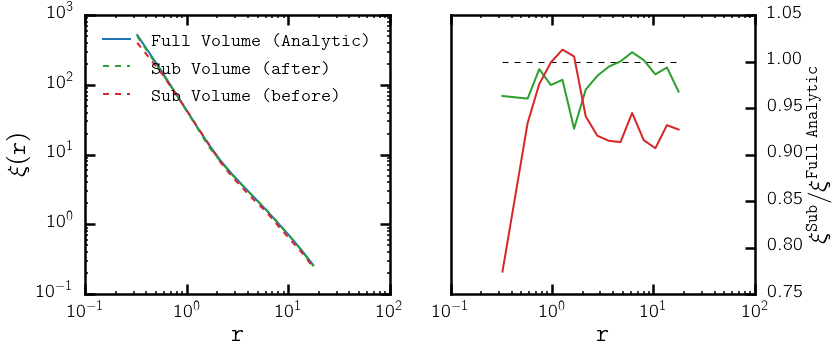

In [11]:
prettyplot()
pretty_colors = prettycolors()
fig = plt.figure(figsize=(12, 5))
sub1 = fig.add_subplot(121)
sub1.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_full_analytic, c=pretty_colors[1], lw=2, ls='-', label='Full Volume (Analytic)')
sub1.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_sub_afterpop_avg, c=pretty_colors[5], lw=2, ls='--', label='Sub Volume (after)')
sub1.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_sub_beforepop_avg, c=pretty_colors[7], lw=2, ls='--', label='Sub Volume (before)')
sub1.set_xscale('log')
sub1.set_xlabel(r'$\mathtt{r}$', fontsize=25)
sub1.set_ylabel(r'$\xi\mathtt{(r)}$', fontsize=25)
sub1.set_yscale('log')
sub1.legend(loc='upper right')

sub2 = fig.add_subplot(122)
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), np.repeat(1.0, len(xi_bin)-1), c='k', ls='--')
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_sub_afterpop_avg/xi_full_analytic, c=pretty_colors[5], lw=2, ls='-', label='Sub Volume (after)')
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xi_sub_beforepop_avg/xi_full_analytic, c=pretty_colors[7], lw=2, ls='-', label='Sub Volume (before)')
sub2.set_xscale('log')
sub2.set_xlabel(r'$\mathtt{r}$', fontsize=25)
sub2.set_ylabel(r'$\xi^\mathtt{Sub}/\xi^\mathtt{Full\;Analytic}$', fontsize=25)
sub2.yaxis.tick_right()
sub2.yaxis.set_label_position("right")

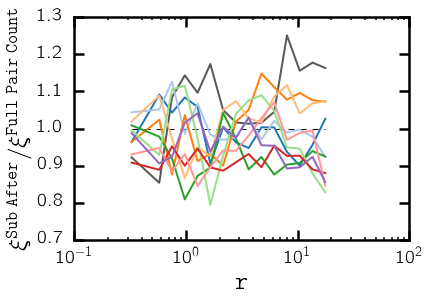

In [12]:
fig = plt.figure()
sub2 = fig.add_subplot(111)
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), np.repeat(1.0, len(xi_bin)-1), c='k', ls='--')
for iii, xiii in enumerate(xi_sub_afterpop_list): 
    sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xiii/xi_full_pc, c=pretty_colors[iii%20], lw=2, ls='-')
sub2.set_xscale('log')
sub2.set_xlabel('r', fontsize=25)
sub2.set_ylabel(r'$\xi^\mathtt{Sub\;After}/\xi^\mathtt{Full\;Pair\;Count}$', fontsize=25)

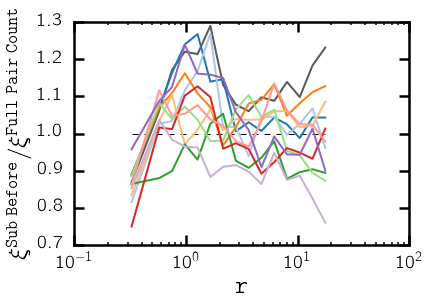

In [13]:
fig = plt.figure()
sub2 = fig.add_subplot(111)
sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), np.repeat(1.0, len(xi_bin)-1), c='k', ls='--')
for iii, xiii in enumerate(xi_sub_beforepop_list): 
    sub2.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), xiii/xi_full_pc, c=pretty_colors[iii%20], lw=2, ls='-')
sub2.set_xscale('log')
sub2.set_xlabel('r', fontsize=25)
sub2.set_ylabel(r'$\xi^\mathtt{Sub\;Before}/\xi^\mathtt{Full\;Pair\;Count}$', fontsize=25)